In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd

Thị trường chứng khoán được biết đến là dễ biến động, luôn thay đổi khó lường và phi tuyến tính. Dự đoán giá cổ phiếu chính xác là vô cùng khó khăn vì phụ thuộc vào nhiều yếu tố vĩ mô và vi mô, chẳng hạn như yếu tố chính trị, bối cảnh kinh tế trong nước và kinh tế toàn cầu, các cú sốc bất ngờ (Covid-19, thiên tai, mất mùa,...), tình hình hoạt động tài chính của công ty, v.v.

Tuy nhiên, tất cả những điều này cũng có nghĩa là có rất nhiều dữ liệu để tìm ra các pattern của chuỗi chứng khoán. Vì vậy, các chuyên gia phân tích tài chính, các nhà nghiên cứu và các nhà khoa học dữ liệu đang tiếp tục khám phá các kỹ thuật phân tích để phát hiện xu hướng và qui luật vận động của thị trường chứng khoán. Điều này đã làm nảy sinh khái niệm giao dịch theo thuật toán (_algorithmic trading_), sử dụng các chiến lược giao dịch tự động, được lập trình sẵn để thực hiện các lệnh.


# Read data

In [3]:
df_business = pd.read_csv('business_train.csv', header = 0)
df_finance = pd.read_csv('finance_train.csv', header = 0)
df_price = pd.read_csv('price_train.csv', header = 0)
print('df_business.shape: ', df_business.shape, '; total symbols: ', len(df_business['symbol'].unique()))
print('df_finance.shape: ', df_finance.shape, '; total symbols: ', len(df_finance['symbol'].unique()))
print('df_price.shape: ', df_price.shape, '; total symbols: ', len(df_price['symbol'].unique()))

df_business.shape:  (823, 5) ; total symbols:  30
df_finance.shape:  (3421, 5) ; total symbols:  30
df_price.shape:  (6149, 7) ; total symbols:  30


# Preprocessing Data

Để thuận tiện xử lý dữ liệu, chúng ta cần sắp xếp những mã chứng khoán này về dạng bảng có các cột là các mã chứng khoán và dòng là chuỗi thời gian.

In [6]:


df_horizontal_symbols = pd.pivot_table(df_price,
               index = 'date',
               columns = 'symbol',
               values = 'close',
               aggfunc = {
                   'close': lambda x: x
               }
              )

df_horizontal_symbols.head(5)

symbol,BID,BVH,CTG,FPT,GAS,HDB,HPG,KDH,MBB,MSN,...,TCB,TCH,TPB,VCB,VHM,VIC,VJC,VNM,VPB,VRE
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,48.25,66.3,35.50,60.2,88.8,24.10,42.30,29.35,23.95,88.9,...,33.00,20.05,27.80,99.0,92.0,108.0,125.8,109.3,34.20,31.65
2021-01-05,47.90,66.0,35.40,62.7,90.0,24.75,42.35,29.40,25.15,89.3,...,33.05,20.05,27.75,99.3,95.6,109.7,124.8,110.8,34.35,33.30
2021-01-06,48.80,66.5,37.85,62.4,90.4,25.65,42.80,30.00,25.30,88.3,...,33.20,20.80,28.00,105.0,94.8,110.2,123.7,109.8,34.40,33.20
2021-01-07,48.90,67.0,38.85,62.5,92.7,26.80,42.80,30.30,25.90,92.0,...,34.60,21.10,28.35,107.0,94.8,110.1,124.6,110.4,34.90,33.90
2021-01-08,48.50,68.3,38.70,63.3,92.7,27.10,42.75,30.50,26.60,93.1,...,35.70,22.55,28.50,104.8,96.4,111.8,126.5,112.0,35.55,35.50


In [7]:
# Kiểm tra nan values:
df_horizontal_symbols.isna().sum()

symbol
BID    0
BVH    0
CTG    0
FPT    0
GAS    0
HDB    0
HPG    0
KDH    0
MBB    0
MSN    0
MWG    0
NVL    1
PDR    0
PLX    0
PNJ    0
POW    0
REE    0
SBT    0
SSI    0
STB    0
TCB    0
TCH    0
TPB    0
VCB    0
VHM    0
VIC    0
VJC    0
VNM    0
VPB    0
VRE    0
dtype: int64

Như vậy đối với mã `NVL` sẽ tồn tại một quan sát NA. Tiếp theo ta sẽ fill giá trị nan này bằng phương pháp feed forward

In [8]:
num_na = df_horizontal_symbols.isna().sum(axis=1)
idx_na = np.where(num_na != 0)[0][0]
df_horizontal_symbols['NVL'].iloc[idx_na-3: idx_na+3]

date
2021-02-04    81.5
2021-02-05    80.2
2021-02-08    77.7
2021-02-09     NaN
2021-02-17    81.0
2021-02-18    81.5
Name: NVL, dtype: float64

Tiếp theo ta sẽ `fill nan` bằng kĩ thuật nội suy tuyến tính (_interpolation_).

In [9]:
df_horizontal_symbols['NVL'] = df_horizontal_symbols['NVL'].interpolate()
df_horizontal_symbols['NVL'].iloc[idx_na-3: idx_na+3]

date
2021-02-04    81.50
2021-02-05    80.20
2021-02-08    77.70
2021-02-09    79.35
2021-02-17    81.00
2021-02-18    81.50
Name: NVL, dtype: float64

Thông thường khi huấn luyện model với LSTM trên dữ liệu tồn tại missing data sẽ dẫn tới những lỗi huấn luyện như hàm loss function bị nan. Chính vì thế chúng ta phải đảm bảo bộ dữ liệu hoàn toàn được fill missing data. Sau khi thu được một bộ dữ liệu sạch, tiếp theo từ bảng giá trên ta biến đổi dữ liệu huấn luyện thành biến đầu vào kích thước `(num_samples, time_step, num_symbols)` và biến mục tiêu kích thước `(num_samples, 1, num_symbols)`

In [10]:
import torch
from sklearn.preprocessing import MinMaxScaler 

# Configure the window size
seq_length = 3 # input time step
num_predict = 1 # number of step in target

def sliding_windows(data, seq_length, num_predict=1):
    x = []
    y = []

    for i in range(data.shape[0]-seq_length-num_predict):
        # _x = data.iloc[i:(i+seq_length), :].values # shape (seq_length, num_symbols)
        # _y = data.iloc[(i+seq_length):(i+seq_length+num_predict), :].values[0] # shape (num_symbols,)
        _x = data[i:(i+seq_length), :] # shape (seq_length, num_symbols)
        _y = data[(i+seq_length):(i+seq_length+num_predict), :][0] # shape (num_symbols,)
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# Scaling dataset
sc = MinMaxScaler()
training_data = sc.fit_transform(df_horizontal_symbols)

X, y = sliding_windows(training_data, seq_length=seq_length, num_predict=num_predict)

print(X.shape, y.shape)
# Train/test split
train_size = int(len(y) * 0.9)
test_size = len(y) - train_size

# Convert into variable
dataX = torch.Tensor(np.array(X))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(X[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

valX = torch.Tensor(np.array(X[train_size:len(X)]))
valY = torch.Tensor(np.array(y[train_size:len(y)]))

print(trainX.shape, valX.shape)
print(trainY.shape, valY.shape)

(201, 3, 30) (201, 30)
torch.Size([180, 3, 30]) torch.Size([21, 3, 30])
torch.Size([180, 30]) torch.Size([21, 30])


# Model (Many-to-Many)



LSTM là một kiến trúc thuộc lớp mô hình RNN. Cấu tạo chung của LSTM là một kiến trúc có dạng truy hồi cho phép dự báo biến mục tiêu tuần tự theo thời gian. Các mô hình LSTM do đó thường được sử dụng phổ biến trong các tác vụ sequence-to-sequence như dịch máy, tóm tắt văn bản. Trong dự báo chuỗi thời gian thì LSTM cũng là một kiến trúc dự báo có độ chính xác cao.

Cấu tạo của một unit cell trong một mạng LSTM sẽ có dạng như bên dưới:

![](https://imgur.com/sRkZ6XW.png)

Bạn đọc có thể xem qua giải thích về từng bộ phận trong unit tại [LSTM architecture](https://phamdinhkhanh.github.io/2019/04/22/Ly_thuyet_ve_mang_LSTM.html).


Có nhiều cách thức tiếp cận khác nhau cho bài toán dự báo. Dựa trên mô hình LSTM chúng ta có thể xem xét bài toán là một tác vụ dự báo `many-to-many`. Trong đó mỗi một giá trị đầu vào $x^{<i>}$ là một véc tơ window của một mã chứng khoán thứ $i$. Các đầu ra $\hat{y}^{<i>}$ là giá trị dự báo của phiên tiếp theo của chính mã chứng khoán đó.

![](https://imgur.com/2ULRdKm.png)

In [11]:
from torch import nn

class LSTM(nn.Module):
    def __init__(self, num_seq, input_size, hidden_size, num_layers):
        '''
        num_seq: number of output sequence values
        input_size: length of input
        hidden_size: embedding vector for at, xt
        num_layers: total number of RNN layers

        '''
        super(LSTM, self).__init__()
        
        self.num_seq = num_seq
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_seq)

    def forward(self, x):
        
        a_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        # Propagate input through LSTM
        ula, (a_out, c_out) = self.lstm(x, (a_0, c_0))
        
        a_out = a_out.view(-1, self.hidden_size) # N * hidden_size
      
        out = self.fc(a_out) # N * num_classes
        
        return out

# Train model

Bạn có thể thực hiện huấn luyện mô hình LSTM với số lượt epochs là 2000, learning_rate = 0.01; hàm mục tiêu được lựa chọn là MSE và phương pháp Optimizer là Adam như bên dưới:

In [12]:
# 1. Declare paramters:
num_epochs = 2000
learning_rate = 0.01
input_size = 30
hidden_size = 2
num_layers = 1
num_seq = 30

# 2. Initialize model
lstm = LSTM(num_seq, input_size, hidden_size, num_layers)

# 3. Optimizer
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# 4. Train the model
for epoch in range(num_epochs):
    # 4.a. Feed forward
    outputs = lstm(trainX)

    # Don't for get to reset optimizer into zero
    optimizer.zero_grad()

    loss = criterion(outputs, trainY)

    # 4.b. Back propagation    
    # obtain the loss function
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.45344
Epoch: 100, loss: 0.03241
Epoch: 200, loss: 0.02379
Epoch: 300, loss: 0.02075
Epoch: 400, loss: 0.01812
Epoch: 500, loss: 0.01642
Epoch: 600, loss: 0.01553
Epoch: 700, loss: 0.01506
Epoch: 800, loss: 0.01481
Epoch: 900, loss: 0.01467
Epoch: 1000, loss: 0.01459
Epoch: 1100, loss: 0.01454
Epoch: 1200, loss: 0.01452
Epoch: 1300, loss: 0.01448
Epoch: 1400, loss: 0.01446
Epoch: 1500, loss: 0.01444
Epoch: 1600, loss: 0.01448
Epoch: 1700, loss: 0.01443
Epoch: 1800, loss: 0.01446
Epoch: 1900, loss: 0.01442


# Evaluation model

Tiếp theo ta sẽ dự báo mô hình trên toàn bộ tập dữ liệu huấn luyện và visualize độ chính xác của model trên các chuỗi dữ liệu.

In [13]:
# Predict data
lstm.eval()
train_test_predict = lstm(dataX)

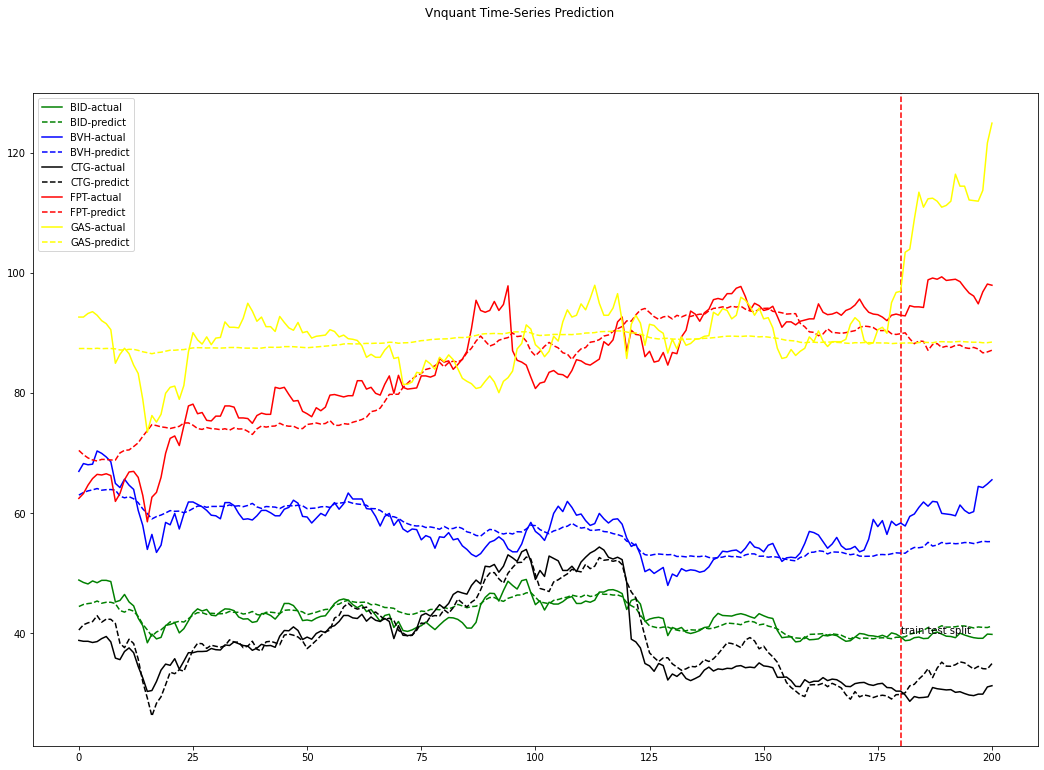

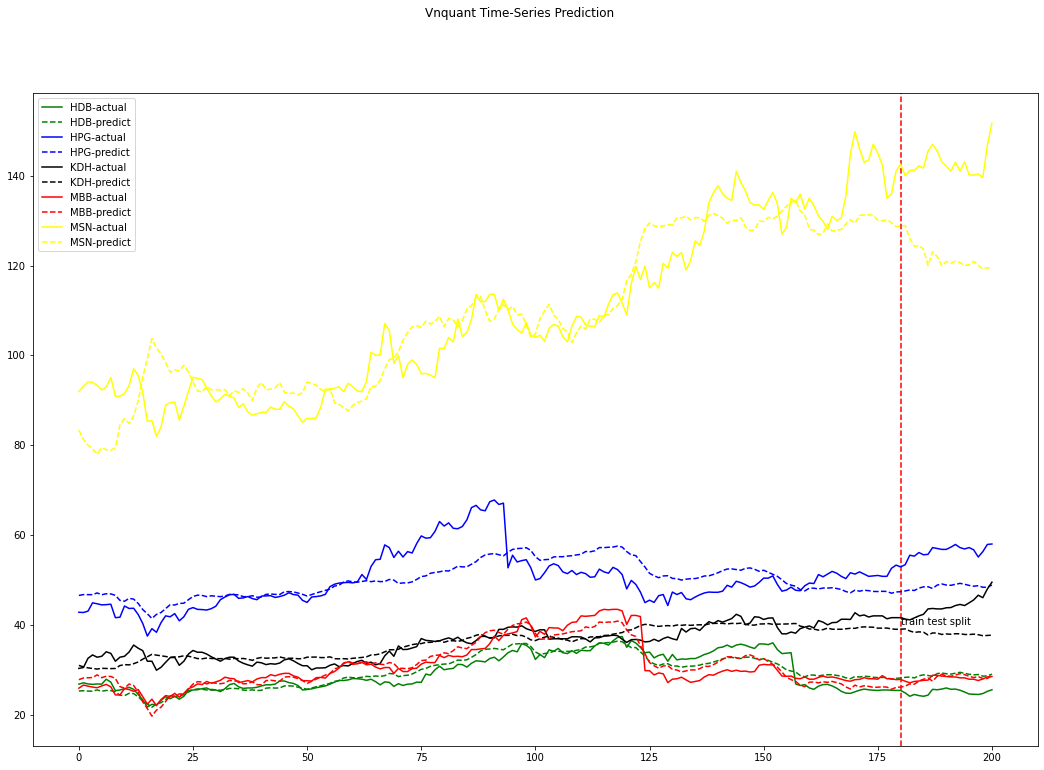

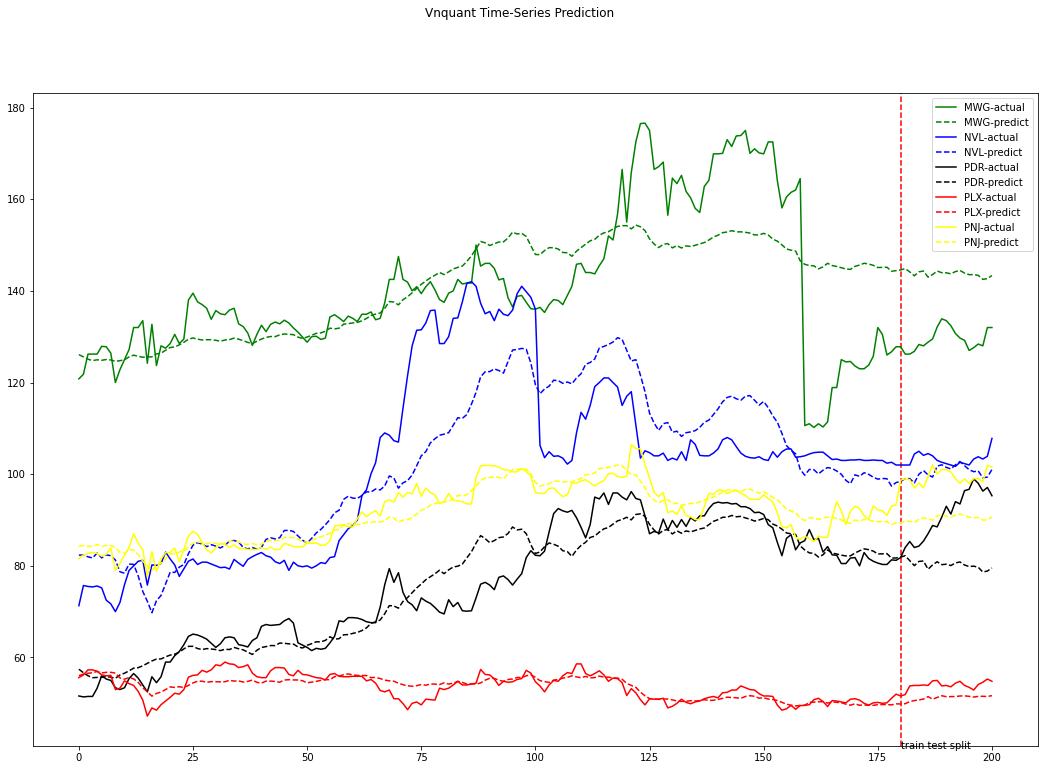

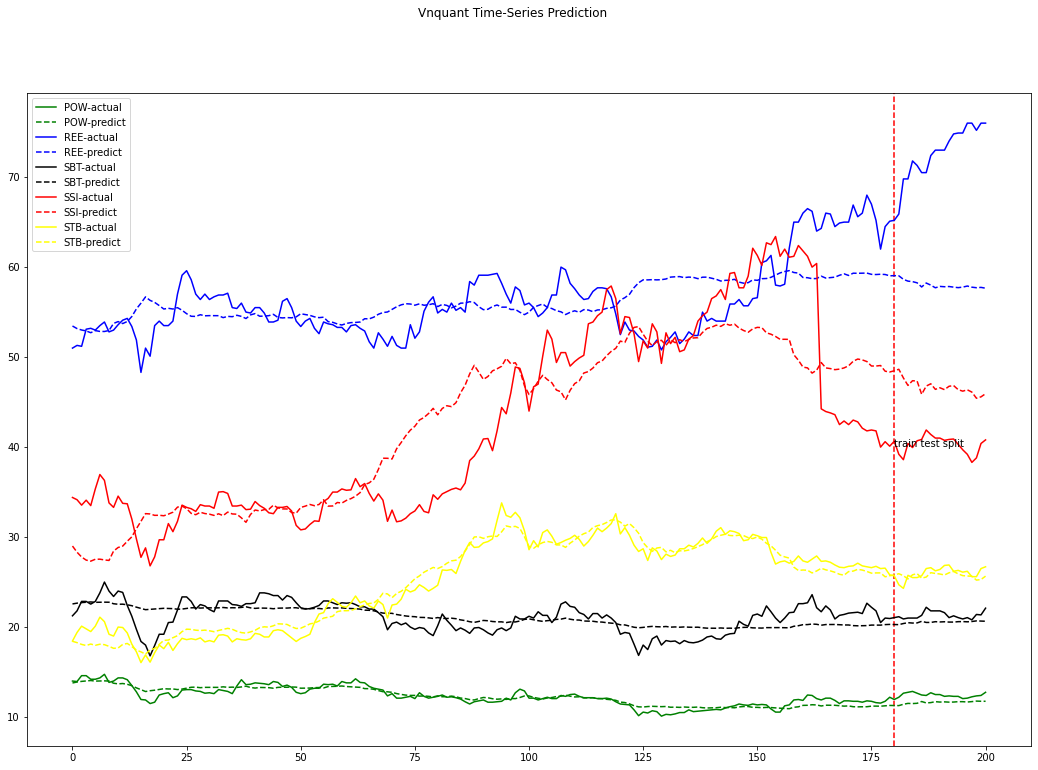

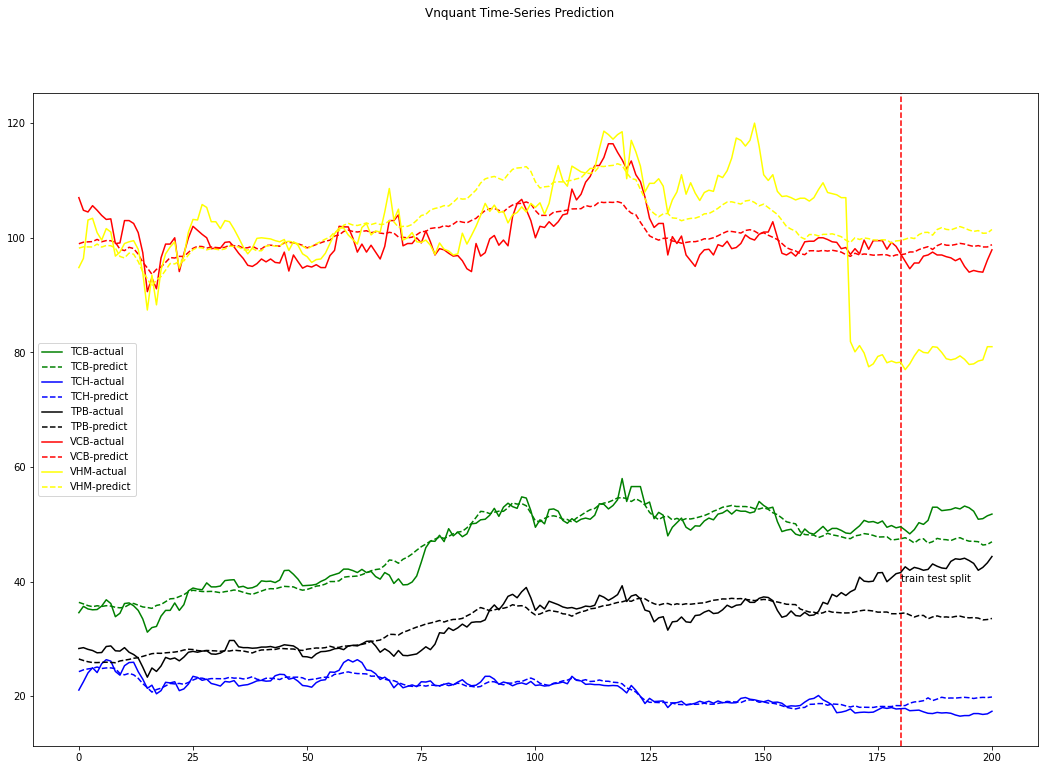

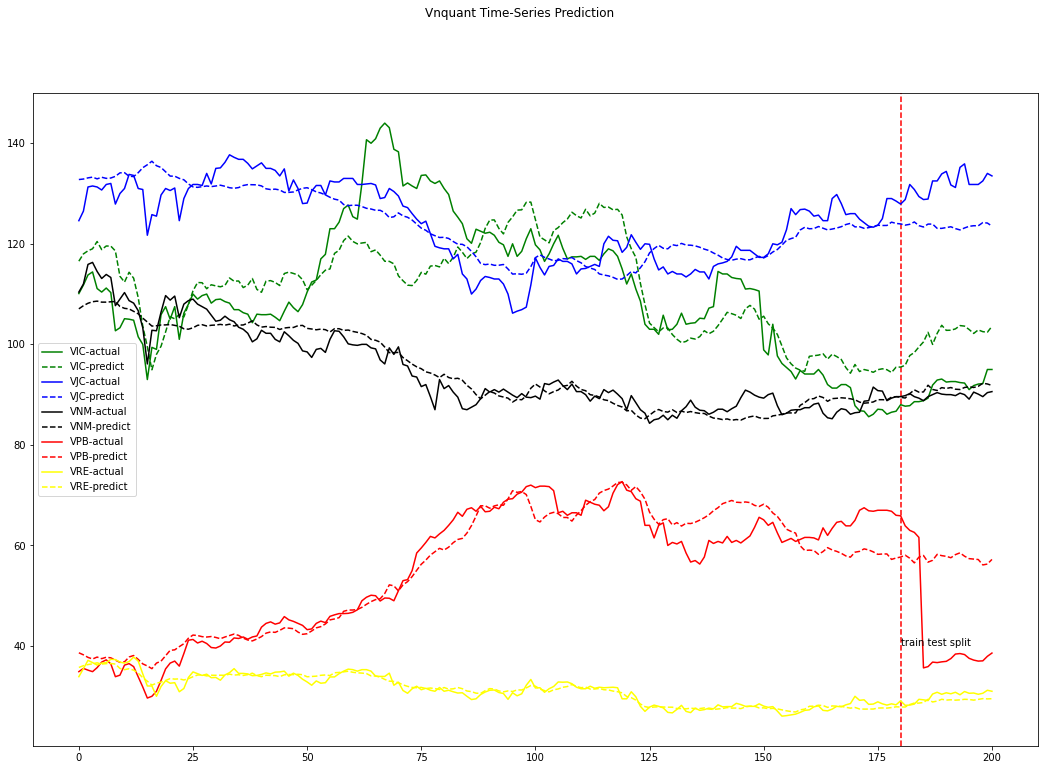

In [14]:
import matplotlib.pyplot as plt

# Convert tensor to numpy
y_predict = train_test_predict.data.numpy()
y_target = dataY.data.numpy()

# Inverse scaling
y_predict = sc.inverse_transform(y_predict)
y_target = sc.inverse_transform(y_target)

# Plot
def plt_line(target, pred, symbols):
    colors = ['green', 'blue', 'black', 'red', 'yellow']
    def _label(symbol, actual = True):
        label = symbol + '-actual' if actual else symbol + '-predict'
        return label
    plt.figure(figsize=(18, 12))
    plt.axvline(x=train_size, c='r', linestyle='--')
    plt.text(x=train_size, y=40, s='train test split')
    for i, symbol in enumerate(symbols):
        plt.plot(target[:, i], label=_label(symbol, True), color=colors[i])
        plt.plot(pred[:, i], label=_label(symbol, False), linestyle='--', color=colors[i])
    plt.legend()
    plt.suptitle('Vnquant Time-Series Prediction')
    plt.show()
    
all_symbols = list(df_horizontal_symbols.columns)
for i in range(6):
    symbols = all_symbols[i*5:(i+1)*5]
    plt_line(y_target[:, i*5:(i+1)*5], y_predict[:, i*5:(i+1)*5], symbols)

# Predict model

Tiếp theo ta sẽ dự báo model trên tập test và submit kết quả

Gộp tập train và val của bước trước và huấn luyện lại model trên toàn bộ tập huấn luyện `(dataX, dataY)`

In [15]:
# 1. Declare paramters:
num_epochs = 2000
learning_rate = 0.01
input_size = 30
hidden_size = 2
num_layers = 1
num_seq = 30

# 2. Initialize model
lstm = LSTM(num_seq, input_size, hidden_size, num_layers)

# 3. Optimizer
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# 4. Train the model
for epoch in range(num_epochs):
    # 4.a. Feed forward
    outputs = lstm(dataX)

    # Don't for get to reset optimizer into zero
    optimizer.zero_grad()

    loss = criterion(outputs, dataY)

    # 4.b. Back propagation    
    # obtain the loss function
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.66882
Epoch: 100, loss: 0.04635
Epoch: 200, loss: 0.02806
Epoch: 300, loss: 0.02538
Epoch: 400, loss: 0.02295
Epoch: 500, loss: 0.02108
Epoch: 600, loss: 0.01972
Epoch: 700, loss: 0.01879
Epoch: 800, loss: 0.01819
Epoch: 900, loss: 0.01782
Epoch: 1000, loss: 0.01760
Epoch: 1100, loss: 0.01747
Epoch: 1200, loss: 0.01738
Epoch: 1300, loss: 0.01735
Epoch: 1400, loss: 0.01730
Epoch: 1500, loss: 0.01728
Epoch: 1600, loss: 0.01727
Epoch: 1700, loss: 0.01726
Epoch: 1800, loss: 0.01726
Epoch: 1900, loss: 0.01725


**Xây dựng vòng lặp huấn luyện**: Dữ liệu cần dự báo là tháng 11/2021. Chúng ta chưa thể biết dữ liệu tại thời điểm này. Khi đó cần xây dựng vòng lặp dịch chuyển mỗi một ngày để dự báo ngày tiếp theo $t+1$. Sau đó sử dụng chính ngày tiếp theo $t+1$ kết hợp với các ngày trước đó để dự báo ngày $t+2$. 

In [17]:
df_price_test = pd.read_csv('price_test.csv', header = 0)
print(df_price_test.shape)
df_price_test.head()

(630, 3)


,date,symbol,close
0,2021-11-01,STB,NaN
1,2021-11-02,STB,NaN
2,2021-11-03,STB,NaN
3,2021-11-04,STB,NaN
4,2021-11-05,STB,NaN


In [18]:
df_horizontal_test = pd.pivot_table(df_price_test,
               index = 'date',
               columns = 'symbol',
               values = 'close',
               aggfunc = {
                   'close': lambda x: -1.
               }
              )

df_horizontal_test.head(5)

symbol,BID,BVH,CTG,FPT,GAS,HDB,HPG,KDH,MBB,MSN,...,TCB,TCH,TPB,VCB,VHM,VIC,VJC,VNM,VPB,VRE
date,,,,,,,,,,,,,,,,,,,,,
2021-11-01,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-11-02,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-11-03,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-11-04,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-11-05,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [19]:
lstm.eval()

init_X = dataX[-1:, :, :]
forecast_dates = list(df_horizontal_test.index)

for i, date in enumerate(forecast_dates): 
    y_batch = lstm(init_X).detach().numpy()
    y_batch = sc.inverse_transform(y_batch)
    df_horizontal_test.loc[date] = y_batch[0]
    init_X = torch.cat([init_X[:, 1:, :], torch.unsqueeze(torch.Tensor(y_batch), axis=0)], axis=1)

df_horizontal_test.head()

symbol,BID,BVH,CTG,FPT,GAS,HDB,HPG,KDH,MBB,MSN,...,TCB,TCH,TPB,VCB,VHM,VIC,VJC,VNM,VPB,VRE
date,,,,,,,,,,,,,,,,,,,,,
2021-11-01,38.148830,56.964310,26.349184,94.989555,100.758148,25.074110,51.166332,42.578991,25.034575,142.430710,...,49.283276,16.793123,39.537216,95.060265,85.802094,86.579811,129.863098,88.982788,49.794121,28.286520
2021-11-02,43.015465,52.933998,43.200672,97.561302,91.898621,35.255573,55.908012,41.336483,36.887836,131.449432,...,56.899502,19.359957,39.099670,103.349586,108.976440,112.190498,113.012123,82.324387,74.233376,27.666718
2021-11-03,43.580708,52.220371,45.335266,98.510658,90.945404,36.729923,56.720829,41.429043,38.557476,131.224701,...,58.311935,19.560616,39.348122,104.468559,112.038437,115.230492,110.501785,80.939957,78.038414,27.409882
2021-11-04,43.650055,52.132824,45.597149,98.627121,90.828461,36.910801,56.820553,41.440399,38.762310,131.197128,...,58.485214,19.585236,39.378601,104.605843,112.414093,115.603447,110.193810,80.770111,78.505226,27.378370
2021-11-05,43.650055,52.132824,45.597149,98.627121,90.828461,36.910801,56.820553,41.440399,38.762310,131.197128,...,58.485214,19.585236,39.378601,104.605843,112.414093,115.603447,110.193810,80.770111,78.505226,27.378370


In [20]:
df_forecast = df_horizontal_test.unstack().reset_index()[['date', 'symbol', 0]]
df_forecast.columns = ['date', 'symbol', 'close']
df_forecast.head()

,date,symbol,close
0,2021-11-01,BID,38.148830
1,2021-11-02,BID,43.015465
2,2021-11-03,BID,43.580708
3,2021-11-04,BID,43.650055
4,2021-11-05,BID,43.650055


In [ ]:
# Sort submission in order of date and symbol like in submission file.
submission = pd.merge(df_price_test, df_forecast,
         left_on=['date', 'symbol'], 
         right_on=['date', 'symbol'], 
         how='inner', 
         suffixes=['_replace', ''])[['date', 'symbol', 'close']]

submission['Id'] = submission[['date', 'symbol']].apply(lambda x: str(x[0])+':'+x[1], axis=1)
submission['Predicted'] = submission['close']
submission[['Id', 'Predicted']].to_csv('submission.csv', index=False)